In [112]:
!pip3 install seaborn

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [122]:
def preprocess_data(df):
    # Convert specific columns to numeric
    columns_to_convert = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts', 'IsActiveMember', 'HasCrCard', 'Exited']
    for column in columns_to_convert:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Define features and target variable
    X = df.drop(columns=['Exited'])  # Drop the target column from X
    Y = df['Exited']  # Target variable

    # Print initial shapes
    print(f"Original X shape: {X.shape}")
    print(f"Original Y shape: {Y.shape}")
    print(f"Target value counts:\n{pd.Series(Y).value_counts()}")

    # Remove redundant columns (first 3 columns)
    X = X.drop(X.columns[:3], axis=1)
    print(f'X after removing features: {X.shape}')

    # Label Encoding for Gender: 'Male' -> 1, 'Female' -> 0
    X['Gender'] = X['Gender'].map({'Male': 1, 'Female': 0})

    # One-Hot Encoding for Geography, generating Geography_Germany and Geography_Spain
    X = pd.get_dummies(X, columns=['Geography'], drop_first=True)

    # Convert boolean columns (True/False) to integers (1/0) for one-hot encoded columns
    X['Geography_Germany'] = X['Geography_Germany'].astype(int)
    X['Geography_Spain'] = X['Geography_Spain'].astype(int)

    # Display processed data
    #print(X.head())

    return X, Y

# Load data
df = pd.read_csv('Churn_Modelling-2.csv')
X, Y = preprocess_data(df)

# Perform train-test split (20% test size)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Original X shape: (10000, 13)
Original Y shape: (10000,)
Target value counts:
Exited
0    7963
1    2037
Name: count, dtype: int64
X after removing features: (10000, 10)
(8000, 11)
(8000,)
(2000, 11)
(2000,)


In [123]:
# Discretizes continuous features in X by replacing each value with the center of the bin it falls into.
def discretize_data(X, num_bins):
    X_discretized = X.copy()
    for column in ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']:
        # Calculate the bin edges for the given column
        bin_edges = np.linspace(X[column].min(), X[column].max(), num_bins + 1)
        # Calculate the center of each bin for replacement
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # Map each value in the column to a bin index based on its position relative to bin edges
        bin_indices = np.digitize(X[column], bin_edges, right=False) - 1
        # Ensure indices are within bounds to avoid any out-of-range errors
        bin_indices = np.clip(bin_indices, 0, len(bin_centers) - 1)
        # Replace values in the column with their corresponding bin center values
        X_discretized[column] = pd.Series(bin_centers[bin_indices], index=X[column].index)
    
    return X_discretized.round().astype(int)

In [124]:
# Trains Decision Tree Classifier (using ID3) on the discretized data.
def train_id3(X_train, X_test, Y_train, Y_test):
    # id3 = DecisionTreeClassifier(class_weight='balanced')  # ID3 algorithm uses 'entropy'
    id3 = DecisionTreeClassifier(
    #criterion='entropy',
    class_weight='balanced',
    random_state=42,
    max_depth=10,  # Increase the depth
    min_samples_split=5,
    min_samples_leaf=2
    )
    # Train the decision tree on the training data
    id3.fit(X_train, Y_train)
    # Make the predictions on the test set
    y_pred_id3 = id3.predict(X_test)
    probabilities = id3.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy_id3, f1_score_id3 = calculate_metrics(Y_test, y_pred_id3)
    return y_pred_id3, accuracy_id3, f1_score_id3, probabilities

In [125]:
# Calcuation of F1_score and Accuracy_score
def calculate_metrics(Y_test, Y_pred):
    tp = np.sum((Y_test == 1) & (Y_pred == 1))
    tn = np.sum((Y_test == 0) & (Y_pred == 0))
    fp = np.sum((Y_test == 0) & (Y_pred == 1))
    fn = np.sum((Y_test == 1) & (Y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return accuracy, f1_score

# Function to calculate TPR and FPR
def calculate_tpr_fpr(y_true, probabilities):
    # Get unique thresholds from predicted probabilities
    thresholds = np.linspace(0, 1, 100)  # 100 thresholds from 0 to 1
    tpr_list = []
    fpr_list = []

    # Loop through thresholds to calculate TPR and FPR
    for threshold in thresholds:
        # Classify based on the threshold
        y_pred = (probabilities >= threshold).astype(int)

        # True Positives, False Positives, True Negatives, False Negatives
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        # Calculate TPR and FPR
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    return np.array(tpr_list), np.array(fpr_list)

In [126]:
# Naive Bayes Class
class NaiveBayes:
    def __init__(self):
        self.class_probs = {}
        self.cond_probs = {}

    def fit(self, X, y):
        # Calculate class probabilities
        self.class_probs = {c: np.mean(y == c) for c in np.unique(y)}

        # Calculate conditional probabilities
        self.cond_probs = {}
        for c in np.unique(y):
            self.cond_probs[c] = {}
            X_c = X[y == c]
            for col in X.columns:
                self.cond_probs[c][col] = X_c[col].value_counts(normalize=True).to_dict()

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            probs = {}
            for c in self.class_probs:
                probs[c] = self.class_probs[c]  # P(C)
                for col in X.columns:
                    value = X.iloc[i][col]
                    # P(X|C)
                    probs[c] *= self.cond_probs[c].get(col, {}).get(value, 1e-6)  # small value for smoothing

            # Choose the class with the highest posterior probability
            predictions.append(max(probs, key=probs.get))
        return np.array(predictions)

    def predict_proba(self, X):
        probabilities = []
        for i in range(len(X)):
            probs = {}
            total_prob = 0  # Total probability for normalization
            for c in self.class_probs:
                probs[c] = self.class_probs[c]  # Start with P(C)
                for col in X.columns:
                    value = X.iloc[i][col]
                    # Multiply by P(X|C) for each feature
                    probs[c] *= self.cond_probs[c].get(col, {}).get(value, 1e-6)
                total_prob += probs[c]  # Sum for normalization

            # Normalize probabilities
            probs = {c: prob / total_prob for c, prob in probs.items()}
            probabilities.append([probs[c] for c in sorted(self.class_probs.keys())])
        
        return np.array(probabilities)

In [127]:
def evaluate_id3(X_train, X_test, Y_train, Y_test):
    # Train and evaluate the ID3 model
    y_pred, accuracy, f1_score, probabilities = train_id3(X_train, X_test, Y_train, Y_test)
    return accuracy, f1_score, probabilities, y_pred

def evaluate_naive_bayes(X_train, X_test, Y_train, Y_test):
    nb = NaiveBayes()
    nb.fit(X_train, Y_train)
    y_pred = nb.predict(X_test)
    accuracy = np.mean(y_pred == Y_test)
    _, f1_score = calculate_metrics(Y_test, y_pred)
    probabilities = nb.predict_proba(X_test)[:, 1]
    return accuracy, f1_score, probabilities


def evaluate_id3_with_naive_bayes(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split):
    # Train Naive Bayes to use as ground truth for ID3
    nb = NaiveBayes()
    nb.fit(X_train_discrete, Y_train_split)
    
    # Predict with Naive Bayes to use as ground truth for ID3
    y_test_true = nb.predict(X_test_discrete)
    
    # Train ID3 with the same training data
    y_pred_id3, _, _, _ = train_id3(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split)
    
    # Calculate F1 score using Naïve Bayes predictions as ground truth
    _, f1_score_id3 = calculate_metrics(y_test_true, y_pred_id3)
    
    return f1_score_id3

def evaluate_naive_bayes_with_decision_tree(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split):
    # Train ID3 (Decision Tree) to use as ground truth for Naive Bayes
    y_pred_decision_tree, _, _, _ = train_id3(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split)

    # Train Naive Bayes with the same training data
    nb = NaiveBayes()
    nb.fit(X_train_discrete, Y_train_split)

    # Predict with Naive Bayes
    y_pred_naive_bayes = nb.predict(X_test_discrete)

    # Calculate F1 score using Decision Tree predictions as ground truth
    _, f1_score_nb = calculate_metrics(y_pred_decision_tree, y_pred_naive_bayes)

    return f1_score_nb
    
# Lists to store results for different bin sizes
def evaluate_model(X, Y, bin_sizes, n_splits, model_name):
    accuracies = {bins: [] for bins in bin_sizes}  # Dictionary to hold accuracies for each bin
    f1_scores = {bins: [] for bins in bin_sizes}   # Dictionary to hold F1 scores for each bin
    f1_scores_id3 = {bins: [] for bins in bin_sizes}  # Dictionary to hold ID3 F1 scores using Naive Bayes as ground truth
    f1_scores_nb = {bins: [] for bins in bin_sizes}  # Dictionary to hold Naive Bayes F1 scores using ID3 as ground truth
    roc_data = {bins: {'fpr': [], 'tpr': [],'auc': [], 'thresholds': []} for bins in bin_sizes} # Dictionary to hold ROC data for each bin

    # Iterate over the number of splits
    for _ in range(n_splits):
        # Create train-test split
        X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X, Y, test_size=0.33, random_state=None)
    
        # Iterate over each bin size
        for bins in bin_sizes:
            # Discretize the data
            X_train_discrete = discretize_data(X_train_split, num_bins=bins)
            X_test_discrete = discretize_data(X_test_split, num_bins=bins)

            if model_name == 'ID3':
                # Train and evaluate the ID3 model
                accuracy, f1_score, probabilities, _ = evaluate_id3(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split)
            elif model_name == 'NaiveBayes':
                accuracy, f1_score, probabilities = evaluate_naive_bayes(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split)
            
            # Store accuracy and F1 score for this bin
            accuracies[bins].append(accuracy)
            f1_scores[bins].append(f1_score)

            # Evaluate ID3 using Naive Bayes predictions as ground truth
            f1_score_id3 = evaluate_id3_with_naive_bayes(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split)
            f1_scores_id3[bins].append(f1_score_id3)

            # Evaluate Naive Bayes using Decision Tree predictions as ground truth
            f1_score_nb = evaluate_naive_bayes_with_decision_tree(X_train_discrete, X_test_discrete, Y_train_split, Y_test_split)
            f1_scores_nb[bins].append(f1_score_nb)

            # Compute TPR and FPR
            tpr, fpr = calculate_tpr_fpr(Y_test_split, probabilities)
            # Ensure FPR and TPR are sorted together by FPR
            sorted_indices = np.argsort(fpr)
            fpr_sorted = fpr[sorted_indices]
            tpr_sorted = tpr[sorted_indices]

            # Calculate the area using the trapezoidal rule
            auc = np.trapezoid(tpr_sorted, fpr_sorted)
            roc_data[bins]['fpr'].append(fpr)
            roc_data[bins]['tpr'].append(tpr)
            roc_data[bins]['auc'] = auc  # Store AUC for each bin size

    return accuracies, f1_scores, f1_scores_id3, f1_scores_nb, roc_data


# Function to calculate max, min, and avg accuracies for each bin size
def calculate_accuracy_metrics(accuracies):
    metrics = {}
    for bins, acc_values in accuracies.items():
        metrics[bins] = {
            "max_accuracy": max(acc_values),
            "min_accuracy": min(acc_values),
            "avg_accuracy": np.mean(acc_values)
        }
    return metrics

# Function to plot max, min, and avg accuracies as separate lines for each bin size
def plot_accuracy(bin_sizes, accuracy_metrics, model_name):
    max_accuracies = [accuracy_metrics[b]["max_accuracy"] for b in bin_sizes]
    min_accuracies = [accuracy_metrics[b]["min_accuracy"] for b in bin_sizes]
    avg_accuracies = [accuracy_metrics[b]["avg_accuracy"] for b in bin_sizes]

    plt.figure(figsize=(12, 6))

    plt.plot(bin_sizes, max_accuracies, marker='o', color='blue', label='Max Accuracy', linewidth=2)
    plt.plot(bin_sizes, min_accuracies, marker='o', color='red', label='Min Accuracy', linewidth=2)
    plt.plot(bin_sizes, avg_accuracies, marker='o', color='green', label='Average Accuracy', linewidth=2)

    plt.xlabel('Number of Bins')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy Metrics vs Number of Bins')
    plt.xticks(bin_sizes)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plots the F1 scores as a function of the number of bins.
def plot_F1(bin_sizes, f1_scores, model_name):
    plt.figure(figsize=(12, 5))
    for bins in bin_sizes:
        plt.plot([bins]*n_splits, f1_scores_id3[bins], marker='o', label=f'F1 Score for Bins: {bins}', linestyle='-', linewidth=2)

    plt.xlabel('Number of Bins')
    plt.ylabel('F1 Score')
    plt.title(f'{model_name} F1 Score vs Number of Bins')
    plt.xticks(bin_sizes)  # Ensure ticks are at the bin sizes
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_ROC(bin_sizes, roc_data, model_name):
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'brown', 'green', 'red']

    for i, bins in enumerate(bin_sizes):
        # Average the TPR and FPR over all splits for smoother ROC
        mean_fpr = np.mean(roc_data[bins]['fpr'], axis=0)  # Use axis=0 for proper averaging
        mean_tpr = np.mean(roc_data[bins]['tpr'], axis=0)  # Same here

        # Plot the ROC curve
        plt.plot(mean_fpr, mean_tpr, color=colors[i], lw=2, label=f'Bins: {bins}')

    # Diagonal line for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name} across Different Bin Sizes')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Print min, max, and average accuracy for each bin size.
def print_results(bin_sizes, accuracies, f1_scores, model_name):
    for bins in bin_sizes:
        print('Bins:', bins)
        print('Accuracies:', [float(acc) for acc in accuracies[bins]])
        print('Min Accuracy:', np.min(accuracies[bins]))
        print('Max Accuracy:', np.max(accuracies[bins]))
        print('Avg Accuracy:', np.average(accuracies[bins]))
        print('F1 Scores:', [float(score) for score in f1_scores[bins]])  

In [128]:
# Define bin sizes to evaluate
bin_sizes = [5, 10, 15, 20]
n_splits = 5  # Number of train-test splits

Bins: 5
Accuracies: [0.7215151515151516, 0.7478787878787879, 0.7621212121212121, 0.76, 0.7451515151515151]
Min Accuracy: 0.7215151515151516
Max Accuracy: 0.7621212121212121
Avg Accuracy: 0.7473333333333333
F1 Scores: [0.5150395778364116, 0.5565031982942431, 0.5449275362318841, 0.5357561547479485, 0.5361279646993933]
Bins: 10
Accuracies: [0.7527272727272727, 0.7884848484848485, 0.7772727272727272, 0.7754545454545455, 0.7609090909090909]
Min Accuracy: 0.7527272727272727
Max Accuracy: 0.7884848484848485
Avg Accuracy: 0.7709696969696969
F1 Scores: [0.5415730337078652, 0.5686032138442522, 0.5580276608538784, 0.5462339252908757, 0.5478510028653296]
Bins: 15
Accuracies: [0.7403030303030304, 0.786060606060606, 0.7627272727272727, 0.7945454545454546, 0.7609090909090909]
Min Accuracy: 0.7403030303030304
Max Accuracy: 0.7945454545454546
Avg Accuracy: 0.7689090909090909
F1 Scores: [0.5339858618814574, 0.5812574139976274, 0.5528269560251284, 0.5631443298969072, 0.5504273504273504]
Bins: 20
Accuraci

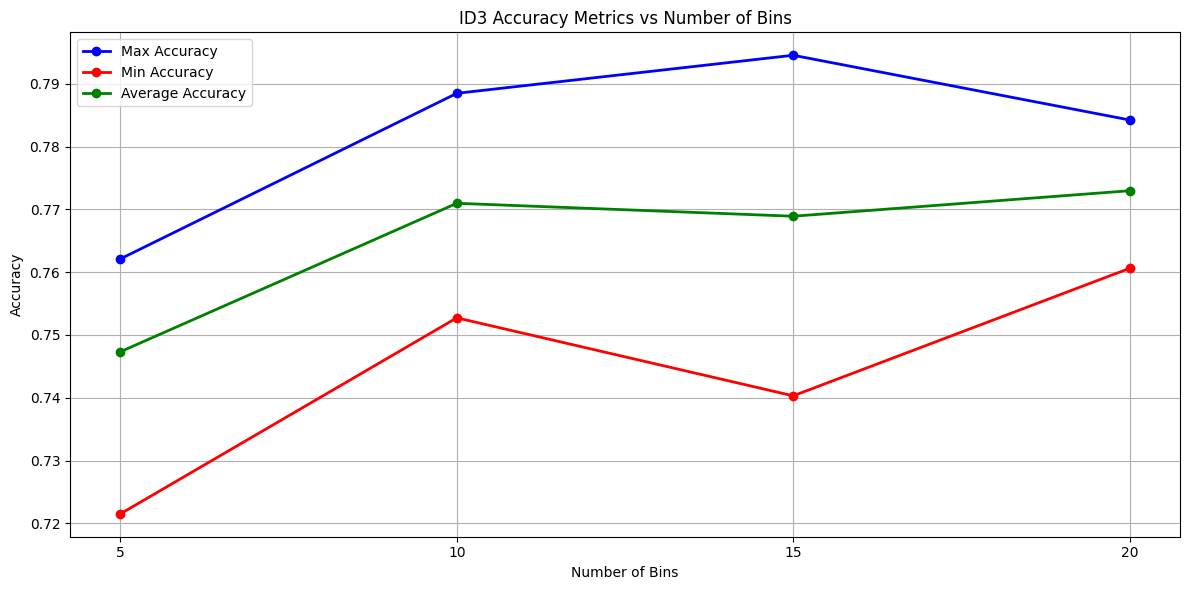

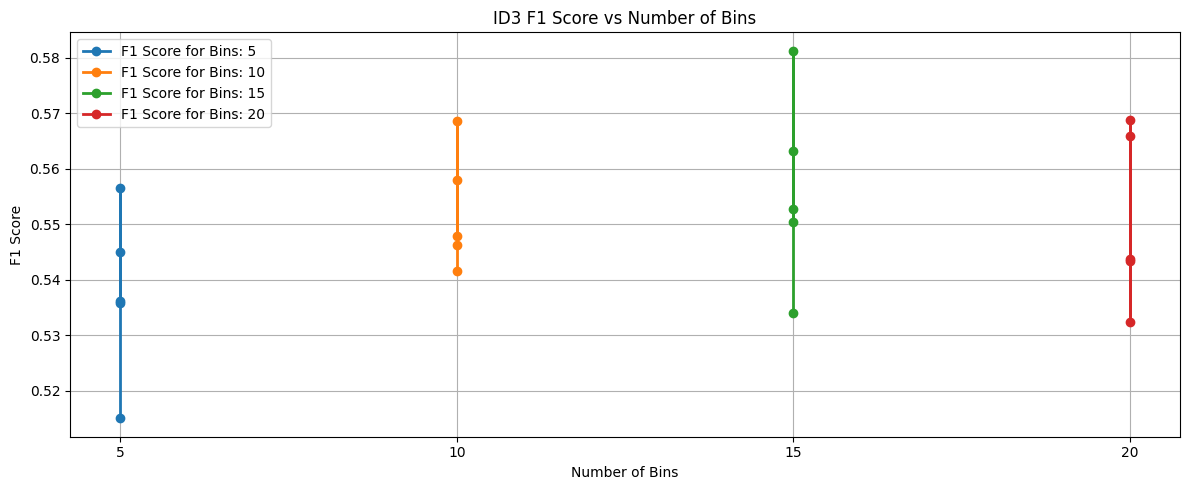

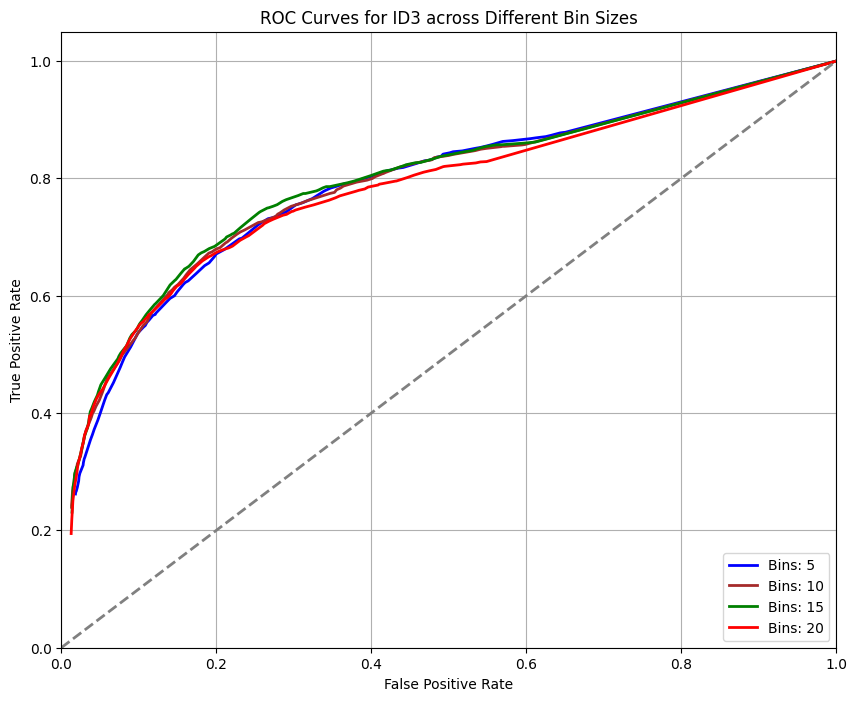

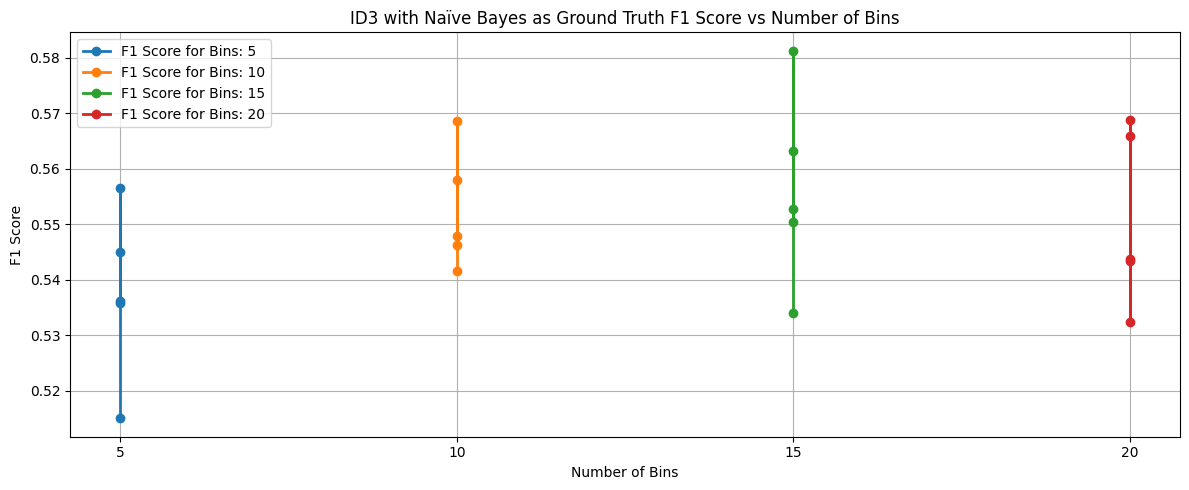

In [129]:
# ID3 Implementation
accuracies_id3, f1_scores_id3, f1_score_id3_gt, _, roc_data = evaluate_model(X, Y, bin_sizes, n_splits, model_name='ID3')
print_results(bin_sizes, accuracies_id3, f1_scores_id3, 'ID3')

# Calculate metrics for accuracies_id3
accuracy_metrics_id3 = calculate_accuracy_metrics(accuracies_id3)
# Plot Accuracy
plot_accuracy(bin_sizes, accuracy_metrics_id3, 'ID3')
# Plot F1 Score
plot_F1(bin_sizes, f1_scores_id3, 'ID3')
# Plot ROC Curve
plot_ROC(bin_sizes, roc_data, 'ID3')
# Plot F1 Score with Naïve Bayes as Ground Truth
plot_F1(bin_sizes, f1_score_id3_gt, 'ID3 with Naïve Bayes as Ground Truth')

Bins: 5
Accuracies: [0.833939393939394, 0.8218181818181818, 0.8251515151515152, 0.8557575757575757, 0.8442424242424242]
Min Accuracy: 0.8218181818181818
Max Accuracy: 0.8557575757575757
Avg Accuracy: 0.8361818181818184
F1 Scores: [0.3978021978021978, 0.3422818791946309, 0.3815648445873527, 0.5475285171102662, 0.528440366972477]
Bins: 10
Accuracies: [0.8357575757575758, 0.8178787878787879, 0.8296969696969697, 0.8590909090909091, 0.8457575757575757]
Min Accuracy: 0.8178787878787879
Max Accuracy: 0.8590909090909091
Avg Accuracy: 0.8376363636363637
F1 Scores: [0.3950892857142857, 0.35306781485468247, 0.3837719298245615, 0.5575642245480494, 0.5434977578475336]
Bins: 15
Accuracies: [0.8342424242424242, 0.8242424242424242, 0.8278787878787879, 0.863030303030303, 0.85]
Min Accuracy: 0.8242424242424242
Max Accuracy: 0.863030303030303
Avg Accuracy: 0.8398787878787879
F1 Scores: [0.4008762322015334, 0.3842887473460722, 0.39316239316239315, 0.5751879699248121, 0.5568487018800359]
Bins: 20
Accuracie

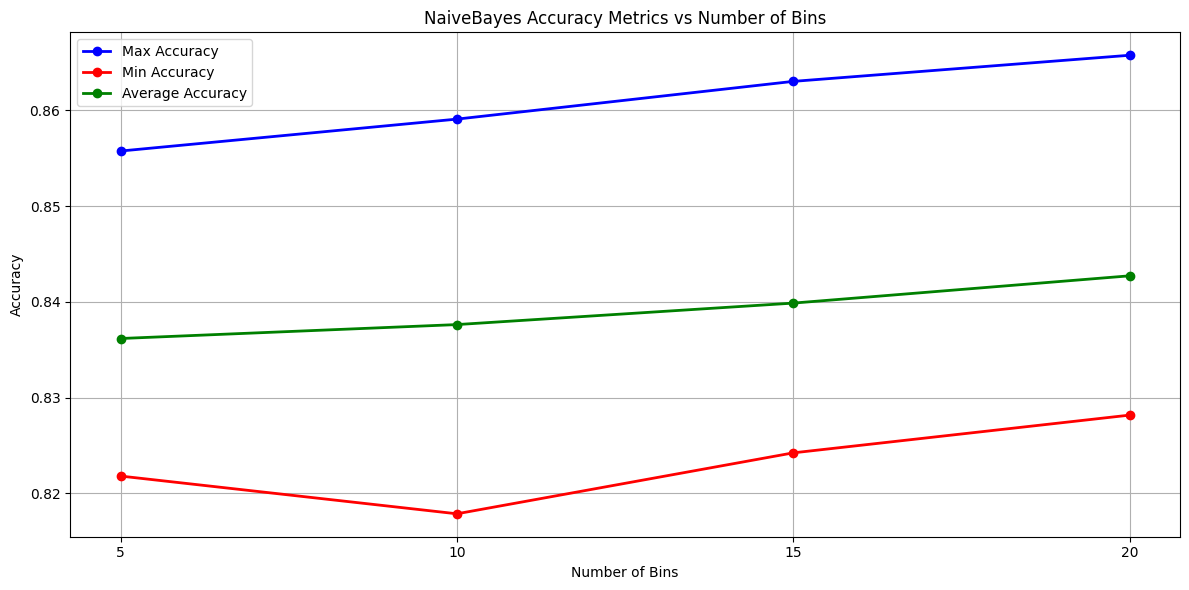

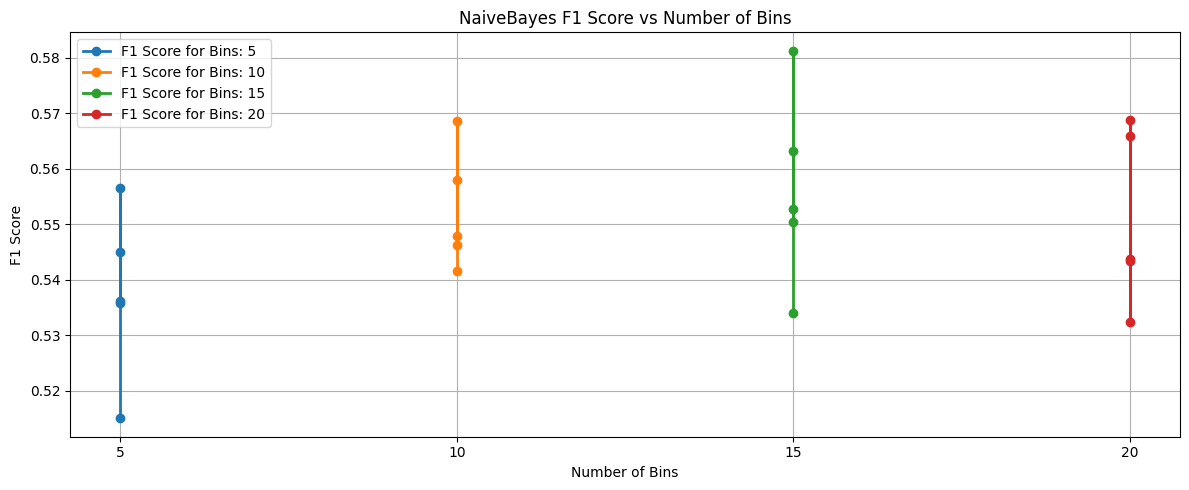

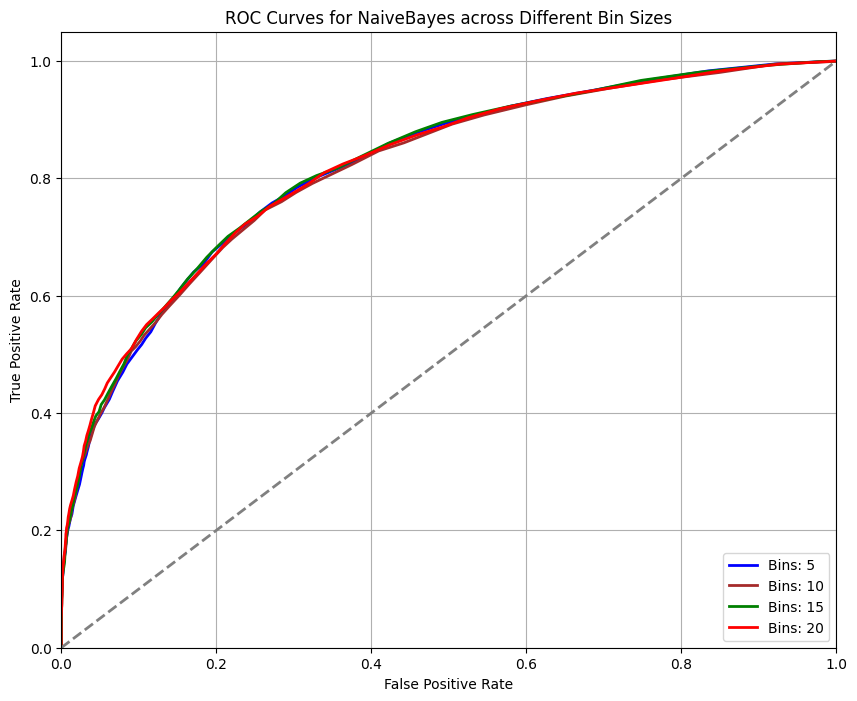

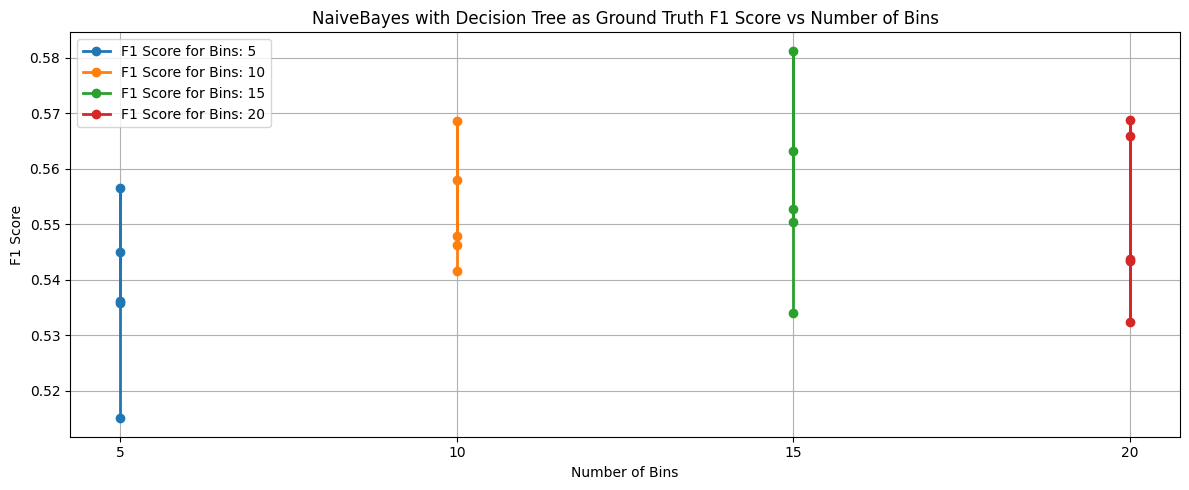

In [130]:
# Naive Bayes Implementation
accuracies_nb, f1_scores_nb, _, f1_scores_nd_gt, roc_data_nb = evaluate_model(X, Y, bin_sizes, n_splits, model_name='NaiveBayes')
print_results(bin_sizes, accuracies_nb, f1_scores_nb, 'NaiveBayes')

# Calculate metrics for accuracies_id3
accuracy_metrics_nb = calculate_accuracy_metrics(accuracies_nb)
# Plot Accuracy
plot_accuracy(bin_sizes, accuracy_metrics_nb, 'NaiveBayes')
# Plot F1 Score
plot_F1(bin_sizes, f1_scores_nb, 'NaiveBayes')
# Plot ROC Curve
plot_ROC(bin_sizes, roc_data_nb, 'NaiveBayes')
# Plot F1 Score with Decision Tree as Ground Truth
plot_F1(bin_sizes, f1_scores_nd_gt, 'NaiveBayes with Decision Tree as Ground Truth')

In [118]:
!git add main.ipynb

In [119]:
!git commit -m "Final Code"

[main ade4c00] Final Code
 Committer: Khushbu Borwal <khushbuborwal@khushbus-air.wifi.uc.edu>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly. Run the
following command and follow the instructions in your editor to edit
your configuration file:

    git config --global --edit

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 1 file changed, 73 insertions(+), 6 deletions(-)


In [120]:
!git push origin main

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.20 KiB | 64.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/khushabuborwal/CS6037ML-Group-Assignments-3-ID3-NaiveBayes.git
   32559b7..ade4c00  main -> main
